# Soft Partition of the Agents

This notebook investigates how the reference scenario evolves if:
- The internal cohesion of the large group weakens.
- The influence of the large group over the independent agents growths (absorption phenomenon).

In [1]:
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import tikzplotlib
from multiprocess.pool import Pool

In [2]:
import embedded_voting as ev # Our own module

Direct load of some useful variables and functions.

In [3]:
from embedded_voting.experiments.aggregation import make_generator, make_aggs, f_max, f_renorm
from embedded_voting.experiments.aggregation import handles, colors, evaluate, default_order

In [4]:
n_tries = 10000 # Number of simulations
n_training = 1000 # Number of training samples for trained rules
n_c = 20

## Cohesion

### Computation

We define the correlation matrix (the Euclidian row-normalization is performed by the generator).

In [5]:
def mymatrix_homogeneity(alpha):
    M = np.eye(24)
    for i in range(20):
        M[i] = [alpha**(np.abs(j-i)) for j in range(20)]+[0]*4
    return M

In [6]:
res = np.zeros((9, 11))
list_alpha = [0.1*i for i in range(11)]
with Pool() as p:
    for i, alpha in enumerate(list_alpha[:-1]):
        groups = [1]*24
        features = mymatrix_homogeneity(alpha)
        generator = make_generator(groups=groups, features=features)
        training = generator(n_training)
        testing = generator(n_tries*n_c).reshape(generator.n_voters, n_tries, n_c)
        truth = generator.ground_truth_.reshape(n_tries, n_c)

        list_agg = make_aggs(groups=groups, features=features)
        res[:, i] = evaluate(list_agg=list_agg, truth=truth, testing=testing, training=training, pool=p)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 700.92it/s]


In [7]:
# No need to recompute base case
with open('base_case_results.pkl', 'rb') as f:
    ref_res = pickle.load(f)[:-1]
res[:, -1] = ref_res

We save the results.

In [8]:
with open('cohesion.pkl', 'wb') as f:
    pickle.dump(res, f)

### Display

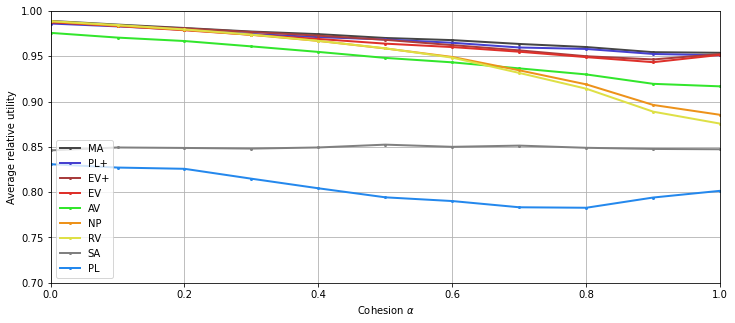

In [9]:
plt.figure(figsize=(12,5))

for i, agg in enumerate(list_agg):
    plt.plot(list_alpha, res[i,:],  'o-', color=colors[agg.name], label=handles[agg.name], 
             linewidth=2, markersize=2)

plt.legend()
plt.xlabel("Cohesion $\\alpha$")
plt.ylabel("Average relative utility")
# plt.title("Alpha")
plt.ylim(0.7,1)
plt.xlim(0,1)
plt.grid()

tikzplotlib.save("cohesion.tex", axis_height ='6cm', axis_width ='8cm')
# save figure:
plt.savefig("cohesion.png")
plt.show()


## Absorption

### Computation

In [10]:
def mymatrix_absorption(beta):
    M = np.eye(5)
    for i in range(4):
        M[i+1,0] = beta
        M[i+1,i+1] = 1-beta     
    return M

In [11]:
res = np.zeros((9, 11))
res[:, 0] = ref_res
list_beta = [0.1*i for i in range(11)]
with Pool() as p:
    for i, beta in enumerate(list_beta[1:]):
        groups = [20]+[1]*4
        features = mymatrix_absorption(beta)
        generator = make_generator(groups=groups, features=features)
        training = generator(n_training)
        testing = generator(n_tries*n_c).reshape(generator.n_voters, n_tries, n_c)
        truth = generator.ground_truth_.reshape(n_tries, n_c)

        list_agg = make_aggs(groups=groups, features=features)
        res[:, i+1] = evaluate(list_agg=list_agg, truth=truth, testing=testing, training=training, pool=p)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 698.80it/s]


We save the results.

In [12]:
with open('absorption.pkl', 'wb') as f:
    pickle.dump(res, f)

### Display

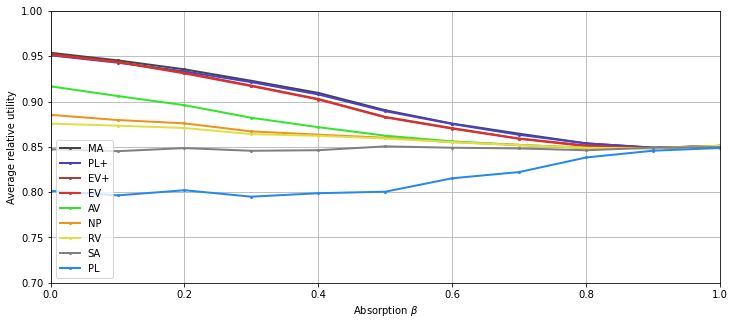

In [13]:
plt.figure(figsize=(12,5))

for i, agg in enumerate(list_agg):
    plt.plot(list_beta, res[i,:],  'o-', color=colors[agg.name], label=handles[agg.name], 
             linewidth=2, markersize=2)

plt.legend()
plt.xlabel("Absorption $\\beta$")
plt.ylabel("Average relative utility")
plt.ylim(0.7,1)
plt.xlim(0,1)
plt.grid()

tikzplotlib.save("absorption.tex", axis_height ='6cm', axis_width ='8cm')
# save figure:
plt.savefig("absorption.png")
plt.show()